# Sentence Transformer

Characteristics of Sentence Transformer (a.k.a bi-encoder) models:

- Calculates a fixed-size vector representation (embedding) given texts or images.
- Embedding calculation is often efficient, embedding similarity calculation is very fast.
- Applicable for a wide range of tasks, such as semantic textual similarity, semantic search, clustering, classification, paraphrase mining, and more.
- Often used as a first step in a two-step retrieval process, where a Cross-Encoder (a.k.a. reranker) model is used to re-rank the top-k results from the bi-encoder.

## Structure of Sentence Transformer Models

The most common architecture is a combination of a Transformer module, a Pooling module, and optionally, a Dense module and/or a Normalize module.

- Transformer: This module is responsible for processing the input text and generating contextualized embeddings.
- Pooling: This module reduces the dimensionality of the output from the Transformer module by aggregating the embeddings. Common pooling strategies include mean pooling and CLS pooling.
- Dense: This module contains a linear layer that post-processes the embedding output from the Pooling module.
- Normalize: This module normalizes the embedding from the previous layer.

In [24]:
from datasets import load_dataset
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.similarity_functions import SimilarityFunction



ds = load_dataset("sentence-transformers/stsb")
trainset = ds['train']
evalset = ds['validation']
testset = ds['test']


eval_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=evalset["sentence1"],
    sentences2=evalset["sentence2"],
    scores=evalset["score"],
    main_similarity=SimilarityFunction.COSINE,  # similarity function
)


In [1]:
from sentence_transformers import SentenceTransformer

# model = SentenceTransformer("all-MiniLM-L6-v2")
model = SentenceTransformer("../../cache/officials/all-MiniLM-L6-v2")

print(model.device)

print("model's struture:\n", model)

print(model[0].auto_model)

/data02/hyzhang10/miniconda3/envs/xp-nlp/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
No sentence-transformers model found with name ../../cache/officials/all-MiniLM-L6-v2. Creating a new one with mean pooling.


cuda:0
model's struture:
 SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
      

In [ ]:
from sentence_transformers import models, SentenceTransformer

""" 
Option 2. load a transformer model
When you initialize a Sentence Transformer model with a pure Transformers model (e.g., BERT, RoBERTa, DistilBERT, T5), Sentence Transformers creates a Transformer module and a Mean Pooling module by default. This provides a simple way to leverage pre-trained language models for sentence embeddings.
"""
model = SentenceTransformer("bert-base-uncased")

""" 
Option 3. build one with specific modules
"""
transformer = models.Transformer("bert-base-uncased")
pooling = models.Pooling(transformer.get_word_embedding_dimension(), pooling_mode="mean")
normalize = models.Normalize()

model = SentenceTransformer(modules=[transformer, pooling, normalize])

In [ ]:
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(sentences)
print(embeddings.shape)
# [3, 384]

# 3. Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
print(similarities)

## Compute embedding 

single-GPU or multi-GPU

In [ ]:
import time

t_s = time.time()
# Create a large list of 100k sentences
sentences = [f"This is sentence {i}" for i in range(100000)]

# ========================= #
# Start the multi-process pool on all available CUDA devices
pool = model.start_multi_process_pool(target_devices=['cuda:2','cuda:6'])

# Compute the embeddings using the multi-process pool
emb = model.encode_multi_process(sentences, pool, show_progress_bar=True)
print("Embeddings computed. Shape:", emb.shape)

# Optional: Stop the processes in the pool
# model.stop_multi_process_pool(pool)
# ========================= #

t_e = time.time()
runtime = t_e - t_s

hours, rem = divmod(runtime, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Execution time: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

In [ ]:
import time

t_s = time.time()
# Create a large list of 100k sentences
sentences = [f"This is sentence {i}" for i in range(100000)]

# ========================= #
emb = model.encode(sentences, show_progress_bar=True)
print("Embeddings computed. Shape:", emb.shape)
# ========================= #

t_e = time.time()
runtime = t_e - t_s

hours, rem = divmod(runtime, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Execution time: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

## Semantic Textual Similarity

In [2]:
sentences1 = [
    "The new movie is awesome",
    "The cat sits outside",
    "A man is playing guitar",
]

sentences2 = [
    "The dog plays in the garden",
    "The new movie is so great",
    "A woman watches TV",
]

# Compute embeddings for both lists
embeddings1 = model.encode(sentences1)
embeddings2 = model.encode(sentences2)

# Compute cosine similarities
print(model.similarity_fn_name)
similarities = model.similarity(embeddings1, embeddings2)
print(similarities)

# Output the pairs with their score
for idx_i, sentence1 in enumerate(sentences1):
    print(sentence1)
    for idx_j, sentence2 in enumerate(sentences2):
        print(f" - {sentence2: <30}: {similarities[idx_i][idx_j]:.4f}")

None
tensor([[ 0.0543,  0.8939, -0.0502],
        [ 0.2838, -0.0029,  0.1310],
        [ 0.2277, -0.0136, -0.0327]])
The new movie is awesome
 - The dog plays in the garden   : 0.0543
 - The new movie is so great     : 0.8939
 - A woman watches TV            : -0.0502
The cat sits outside
 - The dog plays in the garden   : 0.2838
 - The new movie is so great     : -0.0029
 - A woman watches TV            : 0.1310
A man is playing guitar
 - The dog plays in the garden   : 0.2277
 - The new movie is so great     : -0.0136
 - A woman watches TV            : -0.0327


In [3]:
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# Option 1. pre-defined when loads
# similarity_fn_name can be 
import sentence_transformers
model = SentenceTransformer("../../cache/officials/all-MiniLM-L6-v2", 
                            similarity_fn_name=sentence_transformers.SimilarityFunction.DOT)
print(model.similarity_fn_name)

embeddings = model.encode(sentences)
similarities = model.similarity(embeddings, embeddings)
print(similarities)

# Option 2. change after loads
model.similarity_fn_name = sentence_transformers.SimilarityFunction.EUCLIDEAN
print(model.similarity_fn_name)


embeddings = model.encode(sentences)
similarities = model.similarity(embeddings, embeddings)
print(similarities)

No sentence-transformers model found with name ../../cache/officials/all-MiniLM-L6-v2. Creating a new one with mean pooling.


dot
tensor([[25.8639, 17.7555,  2.9173],
        [17.7555, 27.4839,  4.0585],
        [ 2.9173,  4.0585, 30.0839]])
euclidean
tensor([[-0.0000, -4.2234, -7.0791],
        [-4.2234, -0.0000, -7.0321],
        [-7.0791, -7.0321, -0.0000]])


## Semantic Search


In RAG, for the retrieval of the candidate set, we can either use lexical search (e.g. Elasticsearch), or we can use a bi-encoder which is implemented in Sentence Transformers.

Lexical search looks for literal matches of the query words in your document collection. It will not recognize synonyms, acronyms or spelling variations. In contrast, semantic search (or dense retrieval) encodes the search query into vector space and retrieves the document embeddings that are close in vector space. Semantic search overcomes the shortcomings of lexical search and can recognize synonym and acronyms. 



Semantic search seeks to improve search accuracy by understanding the semantic meaning of the search query and the corpus to search over. Semantic search can also perform well given synonyms, abbreviations, and misspellings, unlike keyword search engines that can only find documents based on lexical matches.

- symmetric semantic search: your query and the entries in your corpus are of about the same length and have the same amount of content.An example would be searching for similar questions: Your query could for example be “How to learn Python online?” and you want to find an entry like “How to learn Python on the web?”. For symmetric tasks, you could potentially flip the query and the entries in your corpus.
- asymmetric semantic search: you usually have a short query (like a question or some keywords) and you want to find a longer paragraph answering the query. An example would be a query like “What is Python” and you want to find the paragraph “Python is an interpreted, high-level and general-purpose programming language. Python’s design philosophy …”. For asymmetric tasks, flipping the query and the entries in your corpus usually does not make sense.


### manual implementation

In [ ]:
"""
This is a simple application for sentence embeddings: semantic search

We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.

This script outputs for various queries the top 5 most similar sentences in the corpus.
"""

import torch

from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("../../cache/officials/all-MiniLM-L6-v2")

# Corpus with example sentences
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey.",
]
# Use "convert_to_tensor=True" to keep the tensors on GPU (if available)
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

# Query sentences:
queries = [
    "A man is eating pasta.",
    "Someone in a gorilla costume is playing a set of drums.",
    "A cheetah chases prey on across a field.",
]

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(5, len(corpus))
for query in queries:
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    similarity_scores = embedder.similarity(query_embedding, corpus_embeddings)[0]
    scores, indices = torch.topk(similarity_scores, k=top_k)

    print("\nQuery:", query)
    print("Top 5 most similar sentences in corpus:")

    for score, idx in zip(scores, indices):
        print(corpus[idx], f"(Score: {score:.4f})")

    """
    # Alternatively, we can also use util.semantic_search to perform cosine similarty + topk
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=5)
    hits = hits[0]      #Get the hits for the first query
    for hit in hits:
        print(corpus[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))
    """

### official function

In [4]:
import torch
from sentence_transformers.util import semantic_search
from sentence_transformers import SentenceTransformer


embedder = SentenceTransformer("../../cache/officials/all-MiniLM-L6-v2")

# Corpus with example sentences
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey.",
]
# Use "convert_to_tensor=True" to keep the tensors on GPU (if available)
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

# Query sentences:
queries = [
    "A man is eating pasta.",
    "Someone in a gorilla costume is playing a set of drums.",
    "A cheetah chases prey on across a field.",
]

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(5, len(corpus))

query_embeddings = embedder.encode(queries, convert_to_tensor=True)

# !!! best for semantic_search if both embedding are on the same device 
device = 'cuda:2'
corpus_embeddings = corpus_embeddings.to(device)
query_embeddings = query_embeddings.to(device)

# !!! this function enables parallel search for multi query and corpus
results = semantic_search(query_embeddings, corpus_embeddings, top_k=5)

for query, result in zip(queries, results):
    
    print("\nQuery:", query)
    print("Top 5 most similar sentences in corpus:")
    
    for item in result:
        print(corpus[item['corpus_id']], f"(Score: {item['score']:.4f})")

No sentence-transformers model found with name ../../cache/officials/all-MiniLM-L6-v2. Creating a new one with mean pooling.



Query: A man is eating pasta.
Top 5 most similar sentences in corpus:
A man is eating food. (Score: 0.7035)
A man is eating a piece of bread. (Score: 0.5272)
A man is riding a horse. (Score: 0.1889)
A man is riding a white horse on an enclosed ground. (Score: 0.1047)
A cheetah is running behind its prey. (Score: 0.0980)

Query: Someone in a gorilla costume is playing a set of drums.
Top 5 most similar sentences in corpus:
A monkey is playing drums. (Score: 0.6433)
A woman is playing violin. (Score: 0.2564)
A man is riding a horse. (Score: 0.1389)
A man is riding a white horse on an enclosed ground. (Score: 0.1191)
A cheetah is running behind its prey. (Score: 0.1080)

Query: A cheetah chases prey on across a field.
Top 5 most similar sentences in corpus:
A cheetah is running behind its prey. (Score: 0.8253)
A man is eating food. (Score: 0.1399)
A monkey is playing drums. (Score: 0.1292)
A man is riding a white horse on an enclosed ground. (Score: 0.1097)
A man is riding a horse. (Scor

In [5]:
results

[[{'corpus_id': 0, 'score': 0.7035484910011292},
  {'corpus_id': 1, 'score': 0.5271986126899719},
  {'corpus_id': 3, 'score': 0.1888955980539322},
  {'corpus_id': 6, 'score': 0.10469931364059448},
  {'corpus_id': 8, 'score': 0.09803035110235214}],
 [{'corpus_id': 7, 'score': 0.6432533264160156},
  {'corpus_id': 4, 'score': 0.25641554594039917},
  {'corpus_id': 3, 'score': 0.13887262344360352},
  {'corpus_id': 6, 'score': 0.11909151822328568},
  {'corpus_id': 8, 'score': 0.10798677057027817}],
 [{'corpus_id': 8, 'score': 0.8253212571144104},
  {'corpus_id': 0, 'score': 0.1398952156305313},
  {'corpus_id': 7, 'score': 0.12919360399246216},
  {'corpus_id': 6, 'score': 0.1097416803240776},
  {'corpus_id': 3, 'score': 0.06497801840305328}]]

## embedding clustering

In [6]:
"""
This is a more complex example on performing clustering on large scale dataset.

This examples find in a large set of sentences local communities, i.e., groups of sentences that are highly
similar. You can freely configure the threshold what is considered as similar. A high threshold will
only find extremely similar sentences, a lower threshold will find more sentence that are less similar.

A second parameter is 'min_community_size': Only communities with at least a certain number of sentences will be returned.

The method for finding the communities is extremely fast, for clustering 50k sentences it requires only 5 seconds (plus embedding computation).

In this example, we download a large set of questions from Quora and then find similar questions in this set.
"""

import csv
import os
import time

from sentence_transformers import SentenceTransformer, util

# Model for computing sentence embeddings. We use one trained for similar questions detection
model = SentenceTransformer("../../cache/officials/all-MiniLM-L6-v2")

# We download the Quora Duplicate Questions Dataset (https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs)
# and find similar question in it
url = "http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv"
dataset_path = "quora_duplicate_questions.tsv"
max_corpus_size = 50000  # We limit our corpus to only the first 50k questions


# Check if the dataset exists. If not, download and extract
# Download dataset if needed
if not os.path.exists(dataset_path):
    print("Download dataset")
    util.http_get(url, dataset_path)

# Get all unique sentences from the file
corpus_sentences = set()
with open(dataset_path, encoding="utf8") as fIn:
    reader = csv.DictReader(fIn, delimiter="\t", quoting=csv.QUOTE_MINIMAL)
    for row in reader:
        corpus_sentences.add(row["question1"])
        corpus_sentences.add(row["question2"])
        if len(corpus_sentences) >= max_corpus_size:
            break

corpus_sentences = list(corpus_sentences)
print("Encode the corpus. This might take a while")
corpus_embeddings = model.encode(corpus_sentences, batch_size=64, show_progress_bar=True, convert_to_tensor=True)


No sentence-transformers model found with name ../../cache/officials/all-MiniLM-L6-v2. Creating a new one with mean pooling.


Encode the corpus. This might take a while


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Start clustering
Clustering done after 0.28 sec
Cluster 1, #103 Elements 
Cluster 2, #86 Elements 
Cluster 3, #82 Elements 
Cluster 4, #81 Elements 
Cluster 5, #67 Elements 
Cluster 6, #64 Elements 
Cluster 7, #54 Elements 
Cluster 8, #51 Elements 
Cluster 9, #51 Elements 
Cluster 10, #50 Elements 


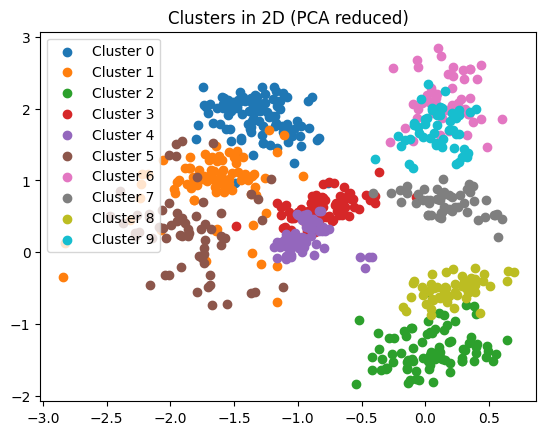

In [7]:
print("Start clustering")
start_time = time.time()

# Two parameters to tune:
# min_cluster_size: Only consider cluster that have at least 25 elements
# threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = util.community_detection(corpus_embeddings, min_community_size=50, threshold=0.75)

print(f"Clustering done after {time.time() - start_time:.2f} sec")

# Print for all clusters the top 3 and bottom 3 elements
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1}, #{len(cluster)} Elements ")
    # for sentence_id in cluster[0:3]:
    #     print("\t", corpus_sentences[sentence_id])
        

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(corpus_embeddings.cpu())


for i, cluster in enumerate(clusters):
    cluster_data = reduced_data[cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {i}")


# Add title and legend
plt.title("Clusters in 2D (PCA reduced)")
plt.legend()
plt.show()

## Paraphrase Mining

Paraphrase mining is the task of finding paraphrases (texts with identical / similar meaning) in a large corpus of sentences.

In [ ]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import paraphrase_mining

model = SentenceTransformer("../../cache/officials/all-MiniLM-L6-v2")
# model = SentenceTransformer("all-MiniLM-L6-v2")

# Single list of sentences - Possible tens of thousands of sentences
sentences = [
    "The cat sits outside",
    "A man is playing guitar",
    "I love pasta",
    "The new movie is awesome",
    "The cat plays in the garden",
    "A woman watches TV",
    "The new movie is so great",
    "Do you like pizza?",
]

paraphrases = paraphrase_mining(model, sentences, top_k=2)

for paraphrase in paraphrases[0:10]:
    score, i, j = paraphrase
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i], sentences[j], score))

## Embedding Quantization

Embeddings may be challenging to scale up, which leads to expensive solutions and high latencies. Currently, many state-of-the-art models produce embeddings with 1024 dimensions, each of which is encoded in float32, i.e., they require 4 bytes per dimension. To perform retrieval over 50 million vectors, you would therefore need around 200GB of memory. This tends to require complex and costly solutions at scale.

However, there is a new approach to counter this problem; it entails reducing the size of each of the individual values in the embedding: Quantization. Experiments on quantization have shown that we can maintain a large amount of performance while significantly speeding up computation and saving on memory, storage, and costs.

In [8]:
"""
Binary quantization refers to the conversion of the float32 values in an embedding to 1-bit values, resulting in a 32x reduction in memory and storage usage. 
To quantize float32 embeddings to binary, we simply threshold normalized embeddings at 0: if the value is larger than 0, we make it 1, otherwise we convert it to 0. 
We can use the Hamming Distance to efficiently perform retrieval with these binary embeddings. 
A huge advantage of the Hamming Distance is that it can be easily calculated with 2 CPU cycles, allowing for blazingly fast performance.
"""

from sentence_transformers import SentenceTransformer
from sentence_transformers.quantization import quantize_embeddings

def calculate_data_storage_size(var):
    return var.dtype.itemsize * np.prod(var.shape)

# 1. Load an embedding model
model = SentenceTransformer("../../cache/officials/all-MiniLM-L6-v2")
sentences = ["I am driving to the lake.", "It is a beautiful day."]

normal_embeddings = model.encode(sentences)
print(f'normal_embeddings shape: {normal_embeddings.shape}')
print(f'normal_embeddings size: {calculate_data_storage_size(normal_embeddings)}')

# 2a. Encode some text using "binary" quantization
binary_embeddings = model.encode(sentences, precision="binary")
print(f'binary_embeddings shape: {binary_embeddings.shape}')
print(f'binary_embeddings size: {calculate_data_storage_size(binary_embeddings)}')

# 2b. or, encode some text without quantization & apply quantization afterwards
embeddings = model.encode(sentences)
binary_embeddings = quantize_embeddings(embeddings, precision="binary")
print(f'binary_embeddings shape: {binary_embeddings.shape}')
print(f'binary_embeddings size: {calculate_data_storage_size(binary_embeddings)}')

No sentence-transformers model found with name ../../cache/officials/all-MiniLM-L6-v2. Creating a new one with mean pooling.


normal_embeddings shape: (2, 384)
normal_embeddings size: 3072
binary_embeddings shape: (2, 48)
binary_embeddings size: 96
binary_embeddings shape: (2, 48)
binary_embeddings size: 96


In [9]:
""" 
To convert the float32 embeddings into int8, we use a process called scalar quantization. 
This involves mapping the continuous range of float32 values to the discrete set of int8 values, which can represent 256 distinct levels (from -128 to 127). 
This is done by using a large calibration dataset of embeddings. We compute the range of these embeddings, i.e. the min and max of each of the embedding dimensions. From there, we calculate the steps (buckets) in which we categorize each value.
"""

from sentence_transformers import SentenceTransformer
from sentence_transformers.quantization import quantize_embeddings
from datasets import load_dataset

def calculate_data_storage_size(var):
    return var.dtype.itemsize * np.prod(var.shape)

# 1. Load an embedding model
model = SentenceTransformer("../../cache/officials/all-MiniLM-L6-v2")

# 2. Prepare an example calibration dataset
corpus = load_dataset("nq_open", split="train[:1000]")["question"]
calibration_embeddings = model.encode(corpus)

# 3. Encode some text without quantization & apply quantization afterwards
embeddings = model.encode(["I am driving to the lake.", "It is a beautiful day."])
int8_embeddings = quantize_embeddings(
    embeddings,
    precision="int8",
    calibration_embeddings=calibration_embeddings,
)
# int8_embeddings = quantize_embeddings(
#     embeddings,
#     ranges=np.array([[-1]*384, [1]*384]),
#     precision="int8",
# )

print(f'embeddings shape: {embeddings.shape}')
print(f'embeddings size: {calculate_data_storage_size(embeddings)}')

print(f'int8_embeddings shape: {int8_embeddings.shape}')
print(f'int8_embeddings size: {calculate_data_storage_size(int8_embeddings)}')

No sentence-transformers model found with name ../../cache/officials/all-MiniLM-L6-v2. Creating a new one with mean pooling.


embeddings shape: (2, 384)
embeddings size: 3072
int8_embeddings shape: (2, 384)
int8_embeddings size: 768


In [ ]:
""" 
It is possible to combine binary and scalar quantization to get the best of both worlds: the extreme speed from binary embeddings and the great performance preservation of scalar embeddings with rescoring. 

- Embed the query as float32
- Quantize the query to ubinary
- Search the binary index
- Load the corresponding int8 embeddings
- Rescore the top_k * rescore_multiplier using the float32 query embedding and the int8 document embeddings
- Sort the scores and return the top_k

"""

"""
https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/embedding-quantization/semantic_search_recommended.py
This script showcases a recommended approach to perform semantic search using quantized embeddings with FAISS and usearch.
In particular, it uses binary search with int8 rescoring. The binary search is highly efficient, and its index can be kept
in memory even for massive datasets: it takes (num_dimensions * num_documents / 8) bytes, i.e. 1.19GB for 10 million embeddings.
"""

import json
import os
import time

import faiss
import numpy as np
from datasets import load_dataset
from usearch.index import Index

from sentence_transformers import SentenceTransformer
from sentence_transformers.quantization import quantize_embeddings

# We use usearch as it can efficiently load int8 vectors from disk.

# Load the model
# NOTE: Because we are only comparing questions here, we will use the "query" prompt for everything.
# Normally you don't use this prompt for documents, but only for the queries
# model = SentenceTransformer(
#     "mixedbread-ai/mxbai-embed-large-v1",
#     prompts={"query": "Represent this sentence for searching relevant passages: "},
#     default_prompt_name="query",
# )
model = SentenceTransformer("../../cache/officials/all-MiniLM-L6-v2")

# Load a corpus with texts
dataset = load_dataset("quora", split="train").map(
    lambda batch: {"text": [text for sample in batch["questions"] for text in sample["text"]]},
    batched=True,
    remove_columns=["questions", "is_duplicate"],
)
max_corpus_size = 100_000
corpus = dataset["text"][:max_corpus_size]

# Apply some default query
query = "How do I become a good programmer?"

# Try to load the precomputed binary and int8 indices
if os.path.exists("quora_faiss_ubinary.index"):
    binary_index: faiss.IndexBinaryFlat = faiss.read_index_binary("quora_faiss_ubinary.index")
    int8_view = Index.restore("quora_usearch_int8.index", view=True)

else:
    # Encode the corpus using the full precision
    full_corpus_embeddings = model.encode(corpus, normalize_embeddings=True, show_progress_bar=True)

    # Convert the embeddings to "ubinary" for efficient FAISS search
    ubinary_embeddings = quantize_embeddings(full_corpus_embeddings, "ubinary")
    binary_index = faiss.IndexBinaryFlat(1024)
    binary_index.add(ubinary_embeddings)
    faiss.write_index_binary(binary_index, "quora_faiss_ubinary.index")

    # Convert the embeddings to "int8" for efficiently loading int8 indices with usearch
    int8_embeddings = quantize_embeddings(full_corpus_embeddings, "int8")
    index = Index(ndim=1024, metric="ip", dtype="i8")
    index.add(np.arange(len(int8_embeddings)), int8_embeddings)
    index.save("quora_usearch_int8.index")
    del index

    # Load the int8 index as a view, which does not cost any memory
    int8_view = Index.restore("quora_usearch_int8.index", view=True)


def search(query, top_k: int = 10, rescore_multiplier: int = 4):
    # 1. Embed the query as float32
    start_time = time.time()
    query_embedding = model.encode(query)
    embed_time = time.time() - start_time

    # 2. Quantize the query to ubinary
    start_time = time.time()
    query_embedding_ubinary = quantize_embeddings(query_embedding.reshape(1, -1), "ubinary")
    quantize_time = time.time() - start_time

    # 3. Search the binary index
    start_time = time.time()
    _scores, binary_ids = binary_index.search(query_embedding_ubinary, top_k * rescore_multiplier)
    binary_ids = binary_ids[0]
    search_time = time.time() - start_time

    # 4. Load the corresponding int8 embeddings
    start_time = time.time()
    int8_embeddings = int8_view[binary_ids].astype(int)
    load_time = time.time() - start_time

    # 5. Rescore the top_k * rescore_multiplier using the float32 query embedding and the int8 document embeddings
    start_time = time.time()
    scores = query_embedding @ int8_embeddings.T
    rescore_time = time.time() - start_time

    # 6. Sort the scores and return the top_k
    start_time = time.time()
    indices = (-scores).argsort()[:top_k]
    top_k_indices = binary_ids[indices]
    top_k_scores = scores[indices]
    sort_time = time.time() - start_time

    return (
        top_k_scores.tolist(),
        top_k_indices.tolist(),
        {
            "Embed Time": f"{embed_time:.4f} s",
            "Quantize Time": f"{quantize_time:.4f} s",
            "Search Time": f"{search_time:.4f} s",
            "Load Time": f"{load_time:.4f} s",
            "Rescore Time": f"{rescore_time:.4f} s",
            "Sort Time": f"{sort_time:.4f} s",
            "Total Retrieval Time": f"{quantize_time + search_time + load_time + rescore_time + sort_time:.4f} s",
        },
    )


while True:
    scores, indices, timings = search(query)

    # Output the results
    print(f"Timings:\n{json.dumps(timings, indent=2)}")
    print(f"Query: {query}")
    for score, index in zip(scores, indices):
        print(f"(Score: {score:.4f}) {corpus[index]}")
    print("")

    # 10. Prompt for more queries
    query = input("Please enter a question: ")